In [123]:
# Split data
import shutil
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory

os.makedirs('data', exist_ok=True)
os.makedirs('data/train', exist_ok=True)
os.makedirs('data/test', exist_ok=True)
os.makedirs('data/val', exist_ok=True)

# Split data
IMAGES_PATH = 'images'
for category in os.listdir(IMAGES_PATH):
    if category.startswith('.'):
        continue
    os.makedirs(f'data/train/{category}', exist_ok=True)
    os.makedirs(f'data/test/{category}', exist_ok=True)
    os.makedirs(f'data/val/{category}', exist_ok=True)
    images = os.listdir(f'{IMAGES_PATH}/{category}')
    
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    train_images, val_images = train_test_split(train_images, test_size=0.2, random_state=42)
    current_image_number = 0
    for image in train_images:
        image_name = category + str(current_image_number) + '.jpg'
        shutil.copy(f'{IMAGES_PATH}/{category}/{image}', f'data/train/{category}/{image_name}')
        current_image_number += 1
        
    for image in val_images:
        image_name = category + str(current_image_number) + '.jpg'
        shutil.copy(f'{IMAGES_PATH}/{category}/{image}', f'data/val/{category}/{image_name}')
        current_image_number += 1
        
    for image in test_images:
        image_name = category + str(current_image_number) + '.jpg'
        shutil.copy(f'{IMAGES_PATH}/{category}/{image}', f'data/test/{category}/{image_name}')
        current_image_number += 1
    

In [124]:
import pandas as pd
import os

data_dir = 'data'
image_paths = []
labels = []


for category in os.listdir(f'{data_dir}/train'):
    if category.startswith('.'):
        continue
    for image in os.listdir(f'{data_dir}/train/{category}'):
        image_paths.append(f'{data_dir}/train/{category}/{image}')
        labels.append(category.split('__')[0])      # Plant name

train_df = pd.DataFrame({'filename': image_paths, 'label': labels})

image_paths = []
labels = []

for category in os.listdir(f'{data_dir}/val'):
    if category.startswith('.'):
        continue
    for image in os.listdir(f'{data_dir}/val/{category}'):
        image_paths.append(f'{data_dir}/val/{category}/{image}')
        labels.append(category.split('__')[0])      # Plant name

val_df = pd.DataFrame({'filename': image_paths, 'label': labels})

image_paths = []
labels = []

for category in os.listdir(f'{data_dir}/test'):
    if category.startswith('.'):
        continue
    for image in os.listdir(f'{data_dir}/test/{category}'):
        image_paths.append(f'{data_dir}/test/{category}/{image}')
        labels.append(category.split('__')[0])      # Plant name

test_df = pd.DataFrame({'filename': image_paths, 'label': labels})




In [125]:
#Prepare data after augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range = [0.5, 1.5],
        fill_mode='nearest'
        )

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='label',
        target_size=(150, 150),
        batch_size=32,
        shuffle=True,
        class_mode='categorical')

val_generator = val_datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='label',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')


Found 61308 validated image filenames belonging to 17 classes.
Found 15362 validated image filenames belonging to 17 classes.


In [126]:
# Description of the data
# Number of images in each category
print('Number of images in each category')
print('Train')
print(train_df['label'].value_counts())
NUM_CLASSES = len(train_df['label'].value_counts())



Number of images in each category
Train
label
Cassava        13689
Tomato         11614
Potato          5467
Apple           4180
Grape           3986
Rice            3649
Orange          3524
Soybean         3257
Corn            2463
Peach           1699
Sugercane       1610
Bell_pepper     1582
Cherry          1218
Squash          1174
Strawberry      1000
Blueberry        960
Raspberry        236
Name: count, dtype: int64


In [127]:
#Pre-trained model for plant leaves

from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))


conv_base.trainable = False
model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_13 (Flatten)        (None, 8192)              0         
                                                                 
 dense_31 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 17)                4369      
                                                                 
Total params: 16,816,465
Trainable params: 2,101,777
Non-trainable params: 14,714,688
_________________________________________________________________


In [132]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.Adam(lr=1e-6),
metrics=['acc'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [133]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=60,
    validation_data=val_generator,
    validation_steps=50)

/tmp/ipykernel_2774513/911059594.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/60
100/100 [==============================] - 23s 221ms/step - loss: 0.6412 - acc: 0.7906 - val_loss: 0.3111 - val_acc: 0.8956
Epoch 2/60
100/100 [==============================] - 22s 223ms/step - loss: 0.6915 - acc: 0.7784 - val_loss: 0.3179 - val_acc: 0.8863
Epoch 3/60
100/100 [==============================] - 23s 226ms/step - loss: 0.6477 - acc: 0.7872 - val_loss: 0.2707 - val_acc: 0.9062
Epoch 4/60
100/100 [==============================] - 22s 222ms/step - loss: 0.6459 - acc: 0.7881 - val_loss: 0.2733 - val_acc: 0.9100
Epoch 5/60
100/100 [==============================] - 22s 219ms/step - loss: 0.6310 - acc: 0.7812 - val_loss: 0.2692 - val_acc: 0.9094
Epoch 6/60
100/100 [==============================] - 22s 220ms/step - loss: 0.6560 - acc: 0.7875 - val_loss: 0.2735 - val_acc: 0.9038
Epoch 7/60
100/100 [==============================] - 22s 220ms/step - loss: 0.6786 - acc: 0.7844 - val_loss: 0.2642 - val_acc: 0.9069
Epoch 8/60
100/100 [==============================] - 2

In [136]:
# Fine-tune the model
conv_base.trainable = True

model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(lr=1e-6),
                metrics=['acc'])
model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_generator,
    validation_steps=50)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_2774513/570386346.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/10
100/100 [==============================] - 26s 224ms/step - loss: 0.5864 - acc: 0.8112 - val_loss: 0.2354 - val_acc: 0.9244
Epoch 2/10
100/100 [==============================] - 22s 219ms/step - loss: 0.5296 - acc: 0.8291 - val_loss: 0.2149 - val_acc: 0.9231
Epoch 3/10
100/100 [==============================] - 22s 218ms/step - loss: 0.5347 - acc: 0.8306 - val_loss: 0.2215 - val_acc: 0.9306
Epoch 4/10
100/100 [==============================] - 22s 222ms/step - loss: 0.5346 - acc: 0.8203 - val_loss: 0.2137 - val_acc: 0.9250
Epoch 5/10
100/100 [==============================] - 24s 239ms/step - loss: 0.5181 - acc: 0.8251 - val_loss: 0.2095 - val_acc: 0.9337
Epoch 6/10
100/100 [==============================] - 22s 216ms/step - loss: 0.5258 - acc: 0.8198 - val_loss: 0.2098 - val_acc: 0.9362
Epoch 7/10
100/100 [==============================] - 22s 218ms/step - loss: 0.4792 - acc: 0.8428 - val_loss: 0.1626 - val_acc: 0.9425
Epoch 8/10
100/100 [==============================] - 2

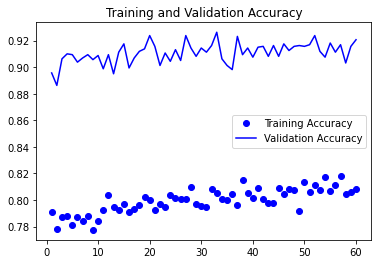

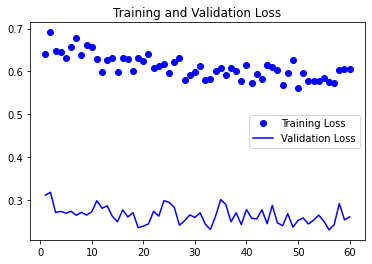

In [137]:
#Plot the results
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label='Training Accuracy')
plt.plot(epochs,val_acc,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'bo',label='Training Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [177]:
# Test the model
test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='filename',
        y_col='label',
        target_size=(150, 150),
        batch_size=1,
        class_mode='categorical',
        shuffle=False
        )

test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)
print('test loss:', test_loss)


Found 19198 validated image filenames belonging to 17 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


19198/19198 [==============================] - 110s 6ms/step - loss: 0.1939 - acc: 0.9372
test acc: 0.9371809363365173
test loss: 0.19389095902442932


19198/19198 [==============================] - 57s 3ms/step


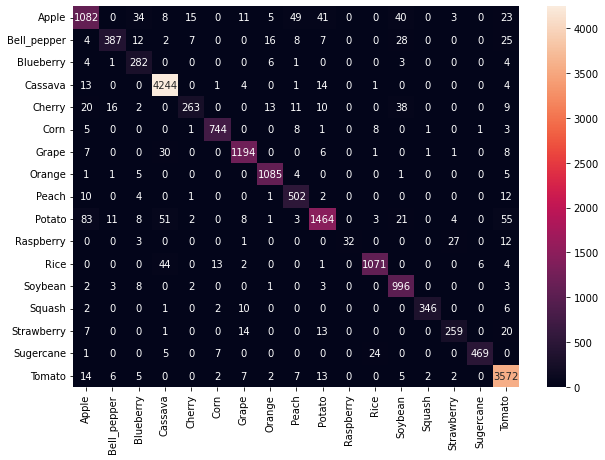

In [178]:
# Print the confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.array(test_generator.classes)

confusion_mtx = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(confusion_mtx, index = [i for i in test_generator.class_indices],
                  columns = [i for i in test_generator.class_indices])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.show()


In [179]:
# Display precision, recall, and F1-score of each class
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))



              precision    recall  f1-score   support

       Apple       0.86      0.83      0.84      1311
 Bell_pepper       0.91      0.78      0.84       496
   Blueberry       0.78      0.94      0.85       301
     Cassava       0.97      0.99      0.98      4282
      Cherry       0.90      0.69      0.78       382
        Corn       0.97      0.96      0.97       772
       Grape       0.95      0.96      0.96      1248
      Orange       0.96      0.98      0.97      1102
       Peach       0.85      0.94      0.89       532
      Potato       0.93      0.85      0.89      1714
   Raspberry       1.00      0.43      0.60        75
        Rice       0.97      0.94      0.95      1141
     Soybean       0.88      0.98      0.93      1018
      Squash       0.99      0.94      0.97       367
  Strawberry       0.88      0.82      0.85       314
   Sugercane       0.99      0.93      0.96       506
      Tomato       0.95      0.98      0.97      3637

    accuracy              